In [65]:
import music21 as m21
from pathlib import Path
import pandas as pd
from collections import Counter
import copy
import shutil
import pretty_midi
import subprocess
import numpy as np

lamarque_path = "../corpus/"
xml_path = "./lamarque_dataset/musicxml"
corrected_xml_path = "./lamarque_dataset/corrected_musicxml"

In [52]:
#run first time to copy files

paths = []
score_ext1 = r"*.xml"
score_ext2 = r"*.musicxml"

copy_counter = 0

for file_path in Path(lamarque_path).iterdir():
    folder = Path(file_path,"ref")
    if folder.exists():
        xml = list(Path(folder).glob(score_ext1))
        musicxml = list(Path(folder).glob(score_ext2))
        if not (len(xml)>0 or len(musicxml)>0):
            print("No score in", str(file_path))
        elif len(xml)+ len(musicxml) >1:
            print("Too many scores in", str(file_path))
        else:
            #copy in our folder
            if len(xml)==1:
                score_path = xml[0]
            else:
                score_path = musicxml[0]
            shutil.copyfile(Path(score_path),Path(xml_path, str(Path(score_path).stem)+".xml"))
            copy_counter+=1

print(copy_counter, "files copied")


No score in ../corpus/116-pop
222 files copied


In [53]:
paths = []

for file_path in Path(xml_path).iterdir():
    try:
        score = m21.converter.parse(str(file_path))
        title = score.metadata.title
        tss = score.recurse().getElementsByClass(m21.meter.TimeSignature)
        if len(tss) > 3:
            print("Skypped", str(file_path))
        ts = score.recurse().getElementsByClass(m21.stream.Measure)[1].timeSignature
        if ts is None:
            ts = score.recurse().getElementsByClass(m21.stream.Measure)[0].timeSignature
        measures = score.recurse().getElementsByClass(m21.stream.Measure)
        paths.append({"path":str(file_path),"time_signature": ts.ratioString, "title": title, "numerator":ts.numerator, "n_measures" : len(measures) })
    except Exception as e:
        print("Problem in", file_path, e)

In [60]:
df = pd.DataFrame(paths)
df

path time_signature  \
0    lamarque_dataset/musicxml/101-Beethoven-bagate...            2/4   
1    lamarque_dataset/musicxml/102-Beethoven-quatuo...            6/8   
2                    lamarque_dataset/musicxml/103.xml            3/8   
3    lamarque_dataset/musicxml/104-Haendel-concerto...            3/4   
4    lamarque_dataset/musicxml/105-Schubert-gloria.xml            2/2   
..                                                 ...            ...   
216  lamarque_dataset/musicxml/413-Beethoven-quinte...            4/4   
217  lamarque_dataset/musicxml/414-Bach-laudamus-te...            4/4   
218  lamarque_dataset/musicxml/419-Beethoven-variat...            3/4   
219  lamarque_dataset/musicxml/449-Clementi-gradus.xml            4/4   
220  lamarque_dataset/musicxml/478-Scriabine-sonate...            4/8   

                                                 title  numerator  n_measures  
0                     101-Beethoven-bagatelle4op33.xml          2          18  
1                             Quatuor 16 op. 135 mvt 2          6          23  
2                                             Elephant          3          16  
3                        Concerto Grosso 4 op. 6 mvt 4          3          15  
4                             Gloria, Messe 2 in G-Dur          2          23  
..                                                 ...        ...         ...  
216                    413-Beethoven-quintetteop16.xml          4          16  
217                           414-Bach-laudamus-te.xml          4          13  
218  Variation XXIII in 24 variations \nsur l'ariet...          3          16  
219                                Gradus ad parnassum          4          16  
220                      478-Scriabine-sonate9op68.xml          4          21  

[221 rows x 5 columns]

In [66]:
np.mean(list(df["n_measures"]))

19.34389140271493

In [55]:
Counter(df.numerator)

Counter({2: 69, 6: 38, 3: 55, 12: 7, 4: 45, 9: 6, 7: 1})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d33742280>]],
      dtype=object)

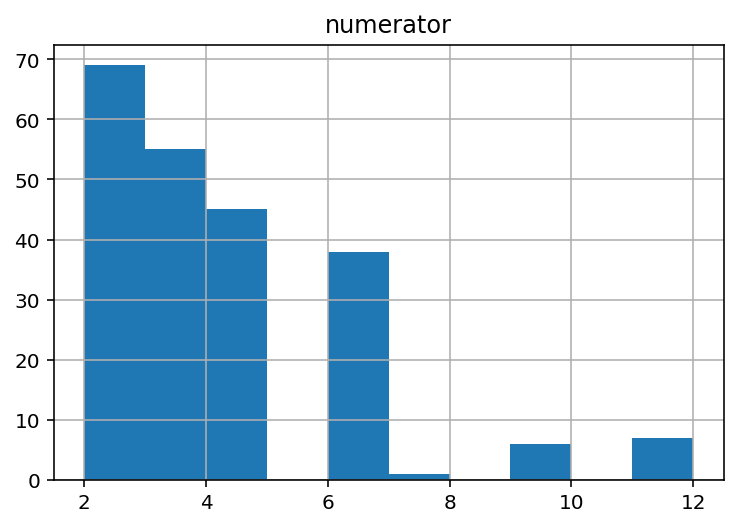

In [57]:
df.hist(column = "numerator")

In [56]:
#check if it's good for each row
for _, r in df.iterrows():
    ts = m21.meter.TimeSignature(r["time_signature"])
    ts_quarter_len = ts.beatCount*ts.beatDuration.quarterLength
    score = m21.converter.parse(str(Path(r["path"])))
    
    measures = score.recurse().getElementsByClass(m21.stream.Measure)
    for m in measures[1:-1]:
        if m.duration.quarterLength != ts_quarter_len:
            print("Problem in",r["path"], "measure", m, measures[m].duration.quarterLength, ts_quarter_len ) 
        if m.timeSignature and m.timeSignature.ratioString != r["time_signature"]:
            print("Problem in",r["path"], "measure", m, measures[m].timeSignature.ratioString, r["time_signature"] ) 

AttributeError: 'int' object has no attribute 'lower'

In [53]:
# Problem in gmmt_dataset/musicxml/46_dichterliebe op.48-1 im wunderschonen monat.xml measure 2 1.5 2.0
# a measure in the middle had an incorrect duration, probably a rest missing. I corrected it

## pad the beginning and the end

In [195]:
def export_cleaned_score(xml_path,time_signature,out_folder):
    #correct ts and pad
    score = m21.converter.parse(str(xml_path))
    ts = m21.meter.TimeSignature(time_signature)
    ts_quarter_len = ts.beatCount*ts.beatDuration.quarterLength
    measures = score.recurse().getElementsByClass(m21.stream.Measure)
    
    #if everything is correct just copy the score (avoid annoying music21 export problems)
    ts_ok = measures[0].timeSignature.ratioString == time_signature
    pickup_ok = measures[0].duration.quarterLength == ts_quarter_len
    last_ok = measures[-1].duration.quarterLength == ts_quarter_len
    if ts_ok and pickup_ok and last_ok:
        print("copied file")
        shutil.copyfile(Path(xml_path),Path(out_folder, str(Path(xml_path).stem)+".xml"))
    else:
        score = correct_score(score,time_signature)
        score = rest_pad_score(score,time_signature)
        score.write("musicxml", Path(out_folder, str(Path(xml_path).stem)+".xml"))
    
def correct_score(score,time_signature):
    #correct the time signature and offset
    measures = score.recurse().getElementsByClass(m21.stream.Measure)
    ts = m21.meter.TimeSignature(time_signature)
    ts_quarter_len = ts.beatCount*ts.beatDuration.quarterLength
    #correct time signature
    m0 = measures[0]
    m0.timeSignature = ts
    for m in measures[1:]:
        m.timeSignature = None
    #correct offsets
    m0.padAsAnacrusis(useInitialRests=False)
    
    return score

def rest_pad_score(score,time_signature):
    measures = score.recurse().getElementsByClass(m21.stream.Measure)
    ts = m21.meter.TimeSignature(time_signature)
    ts_quarter_len = ts.beatCount*ts.beatDuration.quarterLength
    
    #check if measure 0 need to be elongated
    if measures[0].duration.quarterLength != ts_quarter_len:
        initial_duration = m21.duration.Duration()
        initial_duration.quarterLength = ts_quarter_len - measures[0].duration.quarterLength
        for d in initial_duration.components:
            r = m21.note.Rest()
            r.duration.quarterLength = d.quarterLength
            measures[0].insertAndShift(0,r)
#             print("Adding at beginning",d.quarterLength)
        for obj in measures[0]: #fix the elements at beginning such as ts or key
            if not isinstance(obj, m21.note.GeneralNote):
                measures[0].insert(0,copy.deepcopy(obj))
#                 print("removing",obj)
                measures[0].remove(obj)
        #update the paddingleft
        measures[0].padAsAnacrusis(useInitialRests=False)
        
    #check if last measure need to be elongated
    if measures[-1].duration.quarterLength != ts_quarter_len:
        final_duration = m21.duration.Duration()
        final_duration.quarterLength = ts_quarter_len - measures[-1].duration.quarterLength
        for d in final_duration.components:
            r = m21.note.Rest()
            r.duration.quarterLength = d.quarterLength
            measures[-1].append(r)
#         print("Adding at the end")
    
    return score
    
#to uncomment to run
# df.apply(lambda r: export_cleaned_score(r["path"],r["time_signature"],corrected_xml_path), axis = 1)

copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copied file
copi

0      None
1      None
2      None
3      None
4      None
       ... 
294    None
295    None
296    None
297    None
298    None
Length: 299, dtype: object

## export midi file

In [205]:
paths = []

for file_path in Path(corrected_xml_path).iterdir():
    score = m21.converter.parse(str(file_path))
    title = score.metadata.title.replace("@20"," ")
    tss = score.recurse().getElementsByClass(m21.meter.TimeSignature)
    assert(len(tss)==1)
    measures = score.recurse().getElementsByClass(m21.stream.Measure)
    for i, m in enumerate(measures):
        if tss[0].beatCount*tss[0].beatDuration.quarterLength != m.duration.quarterLength:
            print("Problems with", file_path, "measure",i, tss[0].beatCount*tss[0].beatDuration.quarterLength, m.duration.quarterLength)
    paths.append({"path":str(file_path),"time_signature": tss[0].ratioString, "title": title, "numerator":tss[0].numerator, "n_measures" : len(measures) })
#     print(score.metadata.title.replace("@20"," "))

midi_df = pd.DataFrame(paths)

def export_midi(xml_path,time_signature):
    score = m21.converter.parse(str(xml_path))
    score.write('midi', fp=Path(midi_folder_path, str(Path(xml_path).stem)+".mid"))
    
#to uncomment to run    
midi_df.apply(lambda r: export_midi(r["path"],time_signature), axis = 1)

0      None
1      None
2      None
3      None
4      None
       ... 
294    None
295    None
296    None
297    None
298    None
Length: 299, dtype: object

## Transform in temperley note list format

In [228]:
def produce_note_list(midi_path):
    #produce temperley notelist
    mftext_path = str(Path("../temperley_tools/melisma2003/mftext-release-07/mftext"))
    output_path = str(Path("./gmmt_dataset/notelist", Path(midi_path).stem + ".notes"))
    command = str(mftext_path) + " " + str(midi_path) + " > " + output_path
#     print(command)
    print("processing", midi_path)
    subprocess.call(command, shell=True)

for file_path in Path(midi_folder_path).iterdir():
    produce_note_list(file_path)

processing gmmt_dataset/midi/01_Waltz_in_E_flat_Grande_Valse_Brillante_Op.18.mid
processing gmmt_dataset/midi/02_moments_musicaux.mid
processing gmmt_dataset/midi/03_bagatelle__fur_elise__woo.59.mid
processing gmmt_dataset/midi/04_the_preludes_op.28_no.15.mid
processing gmmt_dataset/midi/05_turkish_march.mid
processing gmmt_dataset/midi/06_blumenlied_op.39.mid
processing gmmt_dataset/midi/07_nocturne.mid
processing gmmt_dataset/midi/08_spinnerlied_op.14_no.4.mid
processing gmmt_dataset/midi/09_string_quartet_in_f_major_op.3_no.5_serenade.mid
processing gmmt_dataset/midi/100_sonate_fur_klavier_nr.11_a_dur_k.331_k6.300i_mov.1.mid
processing gmmt_dataset/midi/10_wiegenlied.mid
processing gmmt_dataset/midi/11_solvejgs_lied.mid
processing gmmt_dataset/midi/12_anitras_dans.mid
processing gmmt_dataset/midi/13_traumerei.mid
processing gmmt_dataset/midi/14_menuett_no.2_in_g_maj.mid
processing gmmt_dataset/midi/15_aida_fernando_corena.mid
processing gmmt_dataset/midi/16_william_tell_overture.mid

processing gmmt_dataset/midi/msc-129.mid
processing gmmt_dataset/midi/msc-130.mid
processing gmmt_dataset/midi/msc-131.mid
processing gmmt_dataset/midi/msc-132.mid
processing gmmt_dataset/midi/msc-133.mid
processing gmmt_dataset/midi/msc-134.mid
processing gmmt_dataset/midi/msc-135.mid
processing gmmt_dataset/midi/msc-136.mid
processing gmmt_dataset/midi/msc-137.mid
processing gmmt_dataset/midi/msc-138.mid
processing gmmt_dataset/midi/msc-139.mid
processing gmmt_dataset/midi/msc-140.mid
processing gmmt_dataset/midi/msc-141.mid
processing gmmt_dataset/midi/msc-142.mid
processing gmmt_dataset/midi/msc-143.mid
processing gmmt_dataset/midi/msc-144.mid
processing gmmt_dataset/midi/msc-145.mid
processing gmmt_dataset/midi/msc-146.mid
processing gmmt_dataset/midi/msc-147.mid
processing gmmt_dataset/midi/msc-148.mid
processing gmmt_dataset/midi/msc-149.mid
processing gmmt_dataset/midi/msc-150.mid
processing gmmt_dataset/midi/msc-151.mid
processing gmmt_dataset/midi/msc-152.mid
processing gmmt_

In [25]:
list(Path("../corpus/101-Beethoven-bagatelle4op33/ref/").glob(r"*.xml"))

[PosixPath('../corpus/101-Beethoven-bagatelle4op33/ref/101-Beethoven-bagatelle4op33.xml')]

PosixPath('dataset/ciao/come')